In [1]:
import pandas as pd
import torch
import numpy as np
from sklearn.model_selection import StratifiedShuffleSplit
from pythainlp.tokenize import word_tokenize
# from pythainlp.ulmfit import process_thai


# Config


In [2]:
class Config:
    def __init__(self):
        self.train_texts_path = "./wisesight-sentiment/kaggle-competition/train.txt"
        self.train_labels_path = (
            "./wisesight-sentiment/kaggle-competition/train_label.txt"
        )
        self.test_texts_path = "./wisesight-sentiment/kaggle-competition/test.txt"
        self.test_labels_path = (
            "./wisesight-sentiment/kaggle-competition/test_label.txt"
        )

        self.class_names = ["neg", "neu", "pos", "q"]
        self.seed = 0
        self.device = "cuda"

        self.do_train = True
        self.do_eval = True


config = Config()
device = torch.device(config.device)


# Load Data


In [3]:
# load csv to df
with open(config.train_texts_path, "r") as f:
    train_texts = [line[:-1] for line in f.readlines()]

with open(config.train_labels_path, "r") as f:
    train_labels = [line[:-1] for line in f.readlines()]

with open(config.test_texts_path, "r") as f:
    test_texts = [line[:-1] for line in f.readlines()]

with open(config.test_labels_path, "r") as f:
    test_labels = [line[:-1] for line in f.readlines()]

dev_df = pd.DataFrame({"texts": train_texts, "category": train_labels})
test_df = pd.DataFrame({"texts": test_texts, "category": test_labels})

# drop duplicates
dev_df = dev_df.drop_duplicates()

display(dev_df)
print(dev_df["category"].value_counts())

display(test_df)
print(test_df["category"].value_counts())


,texts,category
0,ประเทศเราผลิตและส่งออกยาสูบเยอะสุดในโลกจิงป่าวคับ,neu
1,คะ,neu
2,อิเหี้ยออมทำกูอยากกินเอ็มเค,neg
3,😅😅😅,neu
4,สวัสดีวันพุธ แนน อะไรนะ,neu
...,...,...
24058,แม่งควายล้วนนน,neg
24059,ดอยสุเทพน้องง ไปหมดแล้วววว #pm25,neg
24060,ค่าชุดอาจจะแพงกว่าส่วนลด,neg
24061,รัฐต้องการแค่ภาษีครับ,neu


neu    13087
neg     6129
pos     4300
q        518
Name: category, dtype: int64


,texts,category
0,ซื้อแต่ผ้าอนามัยแบบเย็นมาค่ะ แบบว่าอีห่ากูนอนไ...,neg
1,ครับ #phithanbkk,neu
2,การด่าไปเหมือนได้บรรเทาความเครียดเฉยๆ แต่บีทีเ...,neg
3,Cf clarins 5 ขวด 2850,neu
4,ทานได้ค่ะ น้ำซุป MK ต้มมาจากหัวผักกาด ซีอิ้วขา...,neu
...,...,...
2669,เล็กลงมา แต่ดีเท่าเดิม 😘 แวะมาหาได้ที่เซเว่นน๊...,pos
2670,แพนด้าซิ่ง กับมุมมองที่แตกต่างอย่างลงตัวในสไตล...,neu
2671,ไปเถอะดอม,pos
2672,เจมส์ บอนด์ ขับโตโยต้าอัลติส 555555555555,neu


neu    1456
neg     683
pos     478
q        57
Name: category, dtype: int64


# Split Train-Validation


In [4]:
# split train-validate by balance category

splitter = StratifiedShuffleSplit(
    n_splits=2, test_size=0.2, train_size=0.8, random_state=config.seed
)

train_indexes, val_indexes = [
    item for item in splitter.split(X=dev_df.texts, y=dev_df.category)
][0]
train_df = dev_df.iloc[train_indexes].reset_index(drop=True)
val_df = dev_df.iloc[val_indexes].reset_index(drop=True)


# Tokenize


In [5]:
train_df["tokenized_texts"] = train_df.apply(
    lambda x: word_tokenize(x["texts"]), axis=1
)

val_df["tokenized_texts"] = train_df.apply(lambda x:  word_tokenize(x["texts"]), axis=1)

test_df["tokenized_texts"] = train_df.apply(lambda x:  word_tokenize(x["texts"]), axis=1)


# Vocab


In [6]:
import torchtext

min_freq = 5
special_tokens = ["<unk>", "<pad>"]

vocab = torchtext.vocab.build_vocab_from_iterator(
    train_df["tokenized_texts"], min_freq=min_freq, specials=special_tokens
)

unk_index = vocab["<unk>"]
pad_index = vocab["<pad>"]
vocab.set_default_index(unk_index)


In [7]:
pad_index

1

# Encode words


In [8]:
def numericalize_data(tokens, vocab):
    ids = [vocab[token] for token in tokens]
    return ids


train_df["x"] = train_df["tokenized_texts"].apply(lambda x: numericalize_data(x, vocab))
val_df["x"] = val_df["tokenized_texts"].apply(lambda x: numericalize_data(x, vocab))
test_df["x"] = test_df["tokenized_texts"].apply(lambda x: numericalize_data(x, vocab))


# # get original lenght
train_df["org_lenght"] = train_df["x"].apply(lambda x: len(x))
val_df["org_lenght"] = val_df["x"].apply(lambda x: len(x))
test_df["org_lenght"] = test_df["x"].apply(lambda x: len(x))


# Encode labels


In [9]:
train_df["y"] = train_df["category"].apply(lambda x: config.class_names.index(x))
val_df["y"] = val_df["category"].apply(lambda x: config.class_names.index(x))
test_df["y"] = test_df["category"].apply(lambda x: config.class_names.index(x))

display(train_df)


,texts,category,tokenized_texts,x,org_lenght,y
0,มะเร็งน่ากลัวมาก ทรมาน เคยเลี้ยงคนป่วยมะเร็ง ส...,neu,"[มะเร็ง, น่ากลัว, มาก, , ทรมาน, , เคย, เลี้ย...","[256, 1886, 33, 2, 2508, 2, 101, 260, 4937, 25...",85,1
1,แสงโสม เรด ลีโอ ช้าง เบนมอร์,neu,"[แสงโสม, , เร, ด, , ลีโอ, , ช้าง, , เบน, ม...","[238, 2, 412, 483, 2, 242, 2, 65, 2, 1562, 110...",12,1
2,สนใจวีออสค่ะ,neu,"[สนใจ, วีออส, ค่ะ]","[302, 690, 23]",3,1
3,จัดสักหน่อยไหม,neu,"[จัด, สักหน่อย, ไหม]","[98, 4356, 100]",3,1
4,เปรียบเทียบระยะห่างของเก้าอี้ชั้นประหยัดสายการ...,neu,"[เปรียบเทียบ, ระยะห่าง, ของ, เก้าอี้, ชั้น, ปร...","[2791, 0, 21, 6282, 254, 551, 4701, 21, 7079, ...",18,1
...,...,...,...,...,...,...
19222,เมื่อวานไปกินสาขาโรบินสันกาญมา ไม่มีสันคอหมูเล...,neg,"[เมื่อวาน, ไป, กิน, สาขา, โรบินสัน, กา, ญ, มา,...","[966, 6, 22, 75, 1090, 430, 2601, 9, 2, 3, 8, ...",45,0
19223,มาดามแป้งหน้าอ่อยกว่าวัย อยากหน้าเด็กมั่ง ต้อง...,pos,"[มาดาม, แป้ง, หน้า, อ่อย, กว่า, วัย, , อยาก, ...","[3045, 201, 84, 5638, 53, 678, 2, 41, 84, 300,...",24,2
19224,ขวดเบียร์ช้าง มีพร้อม 😀😀😀,neu,"[ขวด, เบียร์, ช้าง, , มี, พร้อม, , 😀😀😀]","[133, 50, 65, 2, 8, 107, 2, 0]",8,1
19225,ชอบspy classicกินง่ายอร่อยชอบ🍷💗,pos,"[ชอบ, spy, , classic, กิน, ง่าย, อร่อย, ชอบ, 🍷💗]","[90, 4908, 2, 0, 22, 288, 209, 90, 0]",9,2


# Padding


In [10]:
def padding(sentences, seq_len, pad_index):
    # features = np.zeros((len(sentences), seq_len), dtype=int)
    features = np.ones((len(sentences), seq_len), dtype=int) * pad_index
    print(np.shape(features))

    for ii, review in enumerate(sentences):
        if len(review) != 0:
            features[ii, -len(review) :] = np.array(review)[:seq_len]
            
    return features.tolist()


max_lenght = max(train_df["org_lenght"])
print("max_lenght:", max_lenght)

train_df["x"] = padding(list(train_df["x"]), seq_len=max_lenght, pad_index=pad_index)
val_df["x"] = padding(list(val_df["x"]), seq_len=max_lenght, pad_index=pad_index)
test_df["x"] = padding(list(test_df["x"]), seq_len=max_lenght, pad_index=pad_index)

display(train_df)

max_lenght: 748
(19227, 748)
(4807, 748)
(2674, 748)


,texts,category,tokenized_texts,x,org_lenght,y
0,มะเร็งน่ากลัวมาก ทรมาน เคยเลี้ยงคนป่วยมะเร็ง ส...,neu,"[มะเร็ง, น่ากลัว, มาก, , ทรมาน, , เคย, เลี้ย...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",85,1
1,แสงโสม เรด ลีโอ ช้าง เบนมอร์,neu,"[แสงโสม, , เร, ด, , ลีโอ, , ช้าง, , เบน, ม...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",12,1
2,สนใจวีออสค่ะ,neu,"[สนใจ, วีออส, ค่ะ]","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",3,1
3,จัดสักหน่อยไหม,neu,"[จัด, สักหน่อย, ไหม]","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",3,1
4,เปรียบเทียบระยะห่างของเก้าอี้ชั้นประหยัดสายการ...,neu,"[เปรียบเทียบ, ระยะห่าง, ของ, เก้าอี้, ชั้น, ปร...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",18,1
...,...,...,...,...,...,...
19222,เมื่อวานไปกินสาขาโรบินสันกาญมา ไม่มีสันคอหมูเล...,neg,"[เมื่อวาน, ไป, กิน, สาขา, โรบินสัน, กา, ญ, มา,...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",45,0
19223,มาดามแป้งหน้าอ่อยกว่าวัย อยากหน้าเด็กมั่ง ต้อง...,pos,"[มาดาม, แป้ง, หน้า, อ่อย, กว่า, วัย, , อยาก, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",24,2
19224,ขวดเบียร์ช้าง มีพร้อม 😀😀😀,neu,"[ขวด, เบียร์, ช้าง, , มี, พร้อม, , 😀😀😀]","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",8,1
19225,ชอบspy classicกินง่ายอร่อยชอบ🍷💗,pos,"[ชอบ, spy, , classic, กิน, ง่าย, อร่อย, ชอบ, 🍷💗]","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",9,2


# DataLoader


In [11]:
import torch
from torch.utils.data import DataLoader, TensorDataset

# create Tensor datasets
train_data = TensorDataset(
    torch.from_numpy(np.array(train_df["x"].tolist())),
    torch.from_numpy(np.array(train_df["y"].tolist())),
    torch.from_numpy(np.array(train_df["org_lenght"].tolist())),
)
valid_data = TensorDataset(
    torch.from_numpy(np.array(val_df["x"].tolist())),
    torch.from_numpy(np.array(val_df["y"].tolist())),
    torch.from_numpy(np.array(val_df["org_lenght"].tolist())),
)
test_data = TensorDataset(
    torch.from_numpy(np.array(test_df["x"].tolist())),
    torch.from_numpy(np.array(test_df["y"].tolist())),
    torch.from_numpy(np.array(test_df["org_lenght"].tolist())),
)


batch_size = 50


train_loader = DataLoader(
    train_data, shuffle=True, batch_size=batch_size, drop_last=True
)
valid_loader = DataLoader(
    valid_data, shuffle=True, batch_size=batch_size, drop_last=True
)
test_loader = DataLoader(test_data, shuffle=True, batch_size=batch_size, drop_last=True)


# Model


In [12]:
from torch import nn
import torch


class LSTMNet(torch.nn.Module):
    def __init__(self, vocab_size, output_size, embedding_dim, hidden_dim):
        super().__init__()
        self.embeddings = nn.Embedding(vocab_size, embedding_dim, padding_idx=0)
        self.dropout = nn.Dropout(0.2)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, batch_first=True)
        self.linear = nn.Linear(hidden_dim, output_size)

    def forward(self, x):
        x = self.embeddings(x)
        x = self.dropout(x)
        lstm_out, (ht, ct) = self.lstm(x)
        return self.linear(ht[-1])


vocab_size = len(vocab)
output_size = len(config.class_names)
embedding_dim = 300
hidden_dim = 256

net = LSTMNet(vocab_size, output_size, embedding_dim, hidden_dim)
net.cuda()
print(net)


LSTMNet(
  (embeddings): Embedding(7330, 300, padding_idx=0)
  (dropout): Dropout(p=0.2, inplace=False)
  (lstm): LSTM(300, 256, batch_first=True)
  (linear): Linear(in_features=256, out_features=4, bias=True)
)


# Train


In [13]:
import torch.nn.functional as F
from sklearn.metrics import mean_squared_error


def train_model(model, train_dl, val_dl, epochs=10, lr=0.001):
    parameters = filter(lambda p: p.requires_grad, model.parameters())
    optimizer = torch.optim.Adam(parameters, lr=lr)
    for i in range(epochs):
        print("epoch:", i)
        print("train")
        model.train()
        sum_loss = 0.0
        total = 0
        for x, y, l in train_dl:
            x = x.long().cuda()
            y = y.long().cuda()
            y_pred = model(x)
            optimizer.zero_grad()

            loss = F.cross_entropy(y_pred, y)

            loss.backward()
            optimizer.step()
            sum_loss += loss.item() * y.shape[0]
            total += y.shape[0]

        val_loss = validation_metrics(model, val_dl)
        if (i % 5 == 1) or True:
            print(
                "train loss %.3f, val loss %.3f"
                % (sum_loss / total, val_loss)
            )


def validation_metrics(model, valid_dl):
    print("val")
    model.eval()
    correct = 0
    total = 0
    sum_loss = 0.0
    for x, y, l in valid_dl:
        x = x.long().cuda()
        y = y.long().cuda()
        y_hat = model(x)
        loss = F.cross_entropy(y_hat, y)
        pred = torch.max(y_hat, 1)[1]
        correct += (pred == y).float().sum()
        total += y.shape[0]
        sum_loss += loss.item() * y.shape[0]
    return sum_loss / total


if config.do_train:
    train_model(model=net, train_dl=train_loader, val_dl=valid_loader, epochs=10)


epoch: 0
train
val
train loss 0.896, val loss 1.338
epoch: 1
train
val
train loss 0.715, val loss 1.600
epoch: 2
train
val
train loss 0.595, val loss 1.937
epoch: 3
train
val
train loss 0.487, val loss 2.295
epoch: 4
train
val
train loss 0.380, val loss 2.756
epoch: 5
train
val
train loss 0.280, val loss 3.371
epoch: 6
train
val
train loss 0.205, val loss 4.034
epoch: 7
train
val
train loss 0.149, val loss 4.664
epoch: 8
train
val
train loss 0.114, val loss 5.027
epoch: 9
train
val
train loss 0.095, val loss 5.700


# Predictor


In [14]:
from typing import List


class MySentimentModel:
    def __init__(self, net, vocab, max_lenght, class_names):
        self.net = net
        self.vocab = vocab
        self.max_lenght = max_lenght
        self.class_names = class_names
        self.net.eval().cuda()

    def predict(self, text: str) -> str:
        batch = self._preprocess(text)
        logits = self.net.forward(batch)
        class_name = config.class_names[np.argmax(logits.detach().cpu().numpy())]
        return class_name

    def _preprocess(self, text: str):
        # tokenize
        tokenized_words = self._tokenize(text)
        # encode
        encoded_words = self._encode(tokenized_words)
        # padding
        encoded_words = self._padding(encoded_words)
        # expand to batch size = 1
        batch = torch.LongTensor([encoded_words]).cuda()
        return batch

    def _tokenize(self, text: str) -> List[str]:
        tokenized_words = word_tokenize(text)
        return tokenized_words

    def _encode(self, tokenized_words: List[str]) -> List[int]:
        return numericalize_data(tokenized_words, vocab)

    def _padding(self, encoded_words: List[int]) -> List[int]:
        features = np.ones(self.max_lenght, dtype=int) * self.vocab["<pad>"]
        features[-len(encoded_words) :] = np.array(encoded_words)[: self.max_lenght]
        return features.tolist()


model = MySentimentModel(
    net=net,
    vocab=vocab,
    max_lenght=max_lenght,
    class_names=config.class_names,
)


# Evaluate


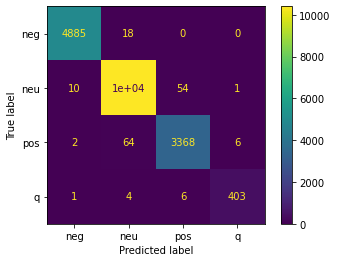

              precision    recall  f1-score   support

         neg       1.00      1.00      1.00      4903
         neu       0.99      0.99      0.99     10470
         pos       0.98      0.98      0.98      3440
           q       0.98      0.97      0.98       414

    accuracy                           0.99     19227
   macro avg       0.99      0.99      0.99     19227
weighted avg       0.99      0.99      0.99     19227



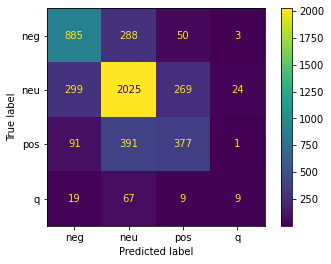

              precision    recall  f1-score   support

         neg       0.68      0.72      0.70      1226
         neu       0.73      0.77      0.75      2617
         pos       0.53      0.44      0.48       860
           q       0.24      0.09      0.13       104

    accuracy                           0.69      4807
   macro avg       0.55      0.51      0.52      4807
weighted avg       0.67      0.69      0.68      4807



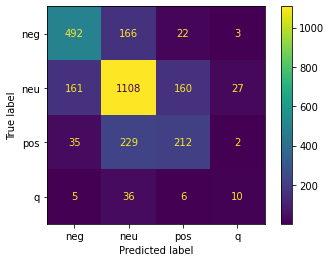

              precision    recall  f1-score   support

         neg       0.71      0.72      0.72       683
         neu       0.72      0.76      0.74      1456
         pos       0.53      0.44      0.48       478
           q       0.24      0.18      0.20        57

    accuracy                           0.68      2674
   macro avg       0.55      0.53      0.53      2674
weighted avg       0.67      0.68      0.68      2674



In [15]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import classification_report


for subset_df in [
    train_df,
    val_df,
    test_df,
]:
    labels = subset_df["category"]
    predictions = [model.predict(text) for text in subset_df["texts"]]

    cm = confusion_matrix(y_true=labels, y_pred=predictions)
    cm_display = ConfusionMatrixDisplay(cm, display_labels=config.class_names)
    cm_display.plot()
    plt.show()

    report = classification_report(y_true=labels, y_pred=predictions)

    print(report)


# Save Artifacts



In [16]:
# save model
torch.save(net.state_dict(), "./artifacts/model.pth")

# save vocab
torch.save(vocab, "./artifacts/vocab.pth")